<a href="https://colab.research.google.com/github/posili/Modulabs_MainProject4/blob/master/Step04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Brazilian E-Commerce Public Dataset/Step02.csv')

#원본 백업
df_step02 = df.copy()

In [10]:
# 특정 카테고리(bed_bath_table) 구매 고객 리스트
bbt_customers = df[df["product_category_name"] == "bed_bath_table"]["customer_unique_id"].unique()

# 해당 고객들의 전체 구매 내역 가져오기
bbt_followup_purchases = df[df["customer_unique_id"].isin(bbt_customers)]

# 'bed_bath_table'이 아닌 다른 카테고리의 구매 건수 집계
bbt_conversion_counts = (
    bbt_followup_purchases[bbt_followup_purchases["product_category_name"] != "bed_bath_table"]
    ["product_category_name"].value_counts()
)

# 상위 5개 카테고리 출력
bbt_conversion_counts.head(5)

,count
product_category_name,
furniture_decor,218
housewares,91
home_confort,58
baby,39
health_beauty,34


<ipython-input-11-d95202dfa712>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bbt_conversion_counts.head(5).values, y=bbt_conversion_counts.head(5).index, palette="coolwarm")


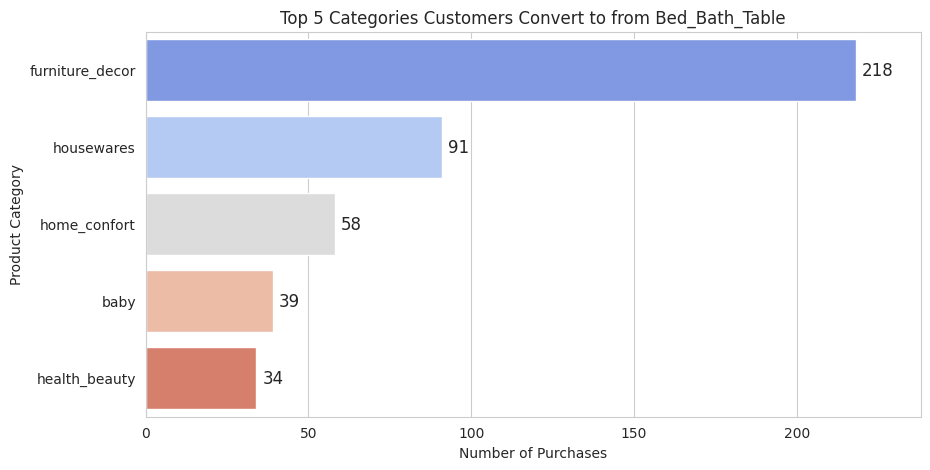

In [11]:
# 시각화를 위한 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set_style("whitegrid")

# 그래프 그리기
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=bbt_conversion_counts.head(5).values, y=bbt_conversion_counts.head(5).index, palette="coolwarm")

# 레이블 추가
plt.xlabel("Number of Purchases")
plt.ylabel("Product Category")
plt.title("Top 5 Categories Customers Convert to from Bed_Bath_Table")

# 수치 정확하게 표시
for index, value in enumerate(bbt_conversion_counts.head(5).values):
    ax.text(value + 2, index, f"{value}", va='center', fontsize=12)

plt.xlim(0, max(bbt_conversion_counts.head(5)) + 20)
plt.show()


### 카이제곱검증 수행
특정 카테고리가 단순히 인기 있는 것인지, Bed_Bath_Table 구매자에게 특별한 연관성이 있는지 알기 위함

In [12]:
from scipy.stats import chi2_contingency

# Bed_Bath_Table 구매자 중 Furniture_Decor 추가 구매 고객 수
bbt_furniture_count = bbt_followup_purchases[bbt_followup_purchases["product_category_name"] == "furniture_decor"]["customer_unique_id"].nunique()

# 비구매자 중 Furniture_Decor 구매 고객 수
non_bbt_furniture_count = df[
    (df["product_category_name"] == "furniture_decor") &
    (~df["customer_unique_id"].isin(bbt_customers))
]["customer_unique_id"].nunique()

# 전체 Bed_Bath_Table 구매 고객 수
bbt_total = len(bbt_customers)

# 전체 고객 수 중 Bed_Bath_Table 미구매자 수
non_bbt_total = len(df["customer_unique_id"].unique()) - bbt_total

# 교차표 구성
contingency_table = [
    [bbt_furniture_count, bbt_total - bbt_furniture_count],  # Bed_Bath_Table 구매자
    [non_bbt_furniture_count, non_bbt_total - non_bbt_furniture_count]  # 비구매자
]

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 결과 출력
print(f"카이제곱 통계량: {chi2:.4f}, p-value: {p:.10f}")

if p < 0.05:
    print("→ Bed_Bath_Table 구매자와 Furniture_Decor 구매 간 유의미한 관계가 있음.")
else:
    print("→ Bed_Bath_Table 구매자와 Furniture_Decor 구매 간 유의미한 관계가 없음.")


카이제곱 통계량: 389.0684, p-value: 0.0000000000
→ Bed_Bath_Table 구매자와 Furniture_Decor 구매 간 유의미한 관계가 있음.


### 전환이 유의미한지 확인하기 위해 전환율 확인

In [13]:
# Bed_Bath_Table을 구매한 전체 고객 수
bbt_total_customers = len(bbt_customers)

# 각 카테고리별 전환율 계산 (Bed_Bath_Table 구매자 중 특정 카테고리도 구매한 고객 비율)
bbt_conversion_rates = (
    bbt_followup_purchases[bbt_followup_purchases["product_category_name"] != "bed_bath_table"]
    .groupby("product_category_name")["customer_unique_id"].nunique() / bbt_total_customers
) * 100

# 전환율 상위 5개 카테고리 확인
bbt_conversion_rates = bbt_conversion_rates.sort_values(ascending=False)

# 결과 출력
bbt_conversion_rates.head(5)


,customer_unique_id
product_category_name,
furniture_decor,1.705850
housewares,0.732641
home_confort,0.590487
baby,0.404593
health_beauty,0.317113


Bed_Bath_Table 고객이 가장 많이 이동하는 카테고리가 furniture_decor인 것은 맞지만, 1.7%에 불과해 전환율을 높일 방안 강구가 남은 숙제.

In [14]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Brazilian E-Commerce Public Dataset/Step04.csv", index=False)